#### 도로 표지판 분류 모델 만들기 <hr>


In [369]:
# ---------------------------------------------------------------------
# 모델링 관련 모듈 로딩
# ---------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassConfusionMatrix
import torchvision.models as models

# ---------------------------------------------------------------------
# 데이터 분석 관련 모듈 로딩
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 이미지 관련 모듈 로딩
# ---------------------------------------------------------------------
from torchvision import transforms

# ---------------------------------------------------------------------
# 기타 모듈 로딩
# ---------------------------------------------------------------------
import os
import pickle

# 활용 패키지 버전 체크
print(f'torch Ver.:{torch.__version__}')
print(f'pandas Ver.:{pd.__version__}')
print(f'numpy Ver.:{np.__version__}')


torch Ver.:2.4.1+cu118
pandas Ver.:2.0.3
numpy Ver.:1.24.4


In [370]:
# DEVICE 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


*   data0.pickle - 셔플링
*   data1.pickle - 셔플링, /255.0 정규화
*   data2.pickle - 셔플링, /255.0 + 평균 정규화
*   data3.pickle - 셔플링, /255.0 + 평균 + STD 정규화
*   data4.pickle - 회색조, 셔플링
*   data5.pickle - 회색조, 셔플링, 로컬 히스토그램 평준화
*   data6.pickle - 회색조, 셔플링, 로컬 히스토그램 평준화, /255.0 정규화
*   data7.pickle - 회색조, 셔플링, 로컬 히스토그램 평준화, /255.0 + 평균 정규화
*   data8.pickle - 회색조, 셔플링, 로컬 히스토그램 평준화, /255.0 + 평균 + STD 정규화


<hr>


In [371]:
# 경로 설정 및 데이터 로드
BASE_DIR = r"C:\Users\Administrator\Desktop\장재웅\traffic_sign_data"
file_path = os.path.join(BASE_DIR, 'data1.pickle')

# pickle 파일 로드
with open(file_path, 'rb') as file:
    data = pickle.load(file)

print('keys:', data.keys())


keys: dict_keys(['x_train', 'y_test', 'x_test', 'x_validation', 'labels', 'y_train', 'y_validation'])


In [372]:
x_train = data['x_train']  # shape: (86989, 32, 3, 32)
y_train = data['y_train']  # shape: (86989,)

x_test = data['x_test']    # shape: (12630, 32, 3, 32)
y_test = data['y_test']    # shape: (12630,)


In [373]:
x_train.shape


(86989, 3, 32, 32)

In [374]:
x_train = x_train.transpose(0, 3, 1, 2)  # (N, H, W, C) → (N, C, H, W)
x_test = x_test.transpose(0, 3, 1, 2)

print("Final shape:", x_train.shape)


Final shape: (86989, 32, 3, 32)


In [375]:
class ImageDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        super().__init__()
        self.features = features.transpose(0, 3, 1, 2)
        self.targets = targets
        self.n_rows = features.shape[0]
        self.transform = transform

    def __getitem__(self, index):
        feature = self.features[index]  # (32, 32, 3) 또는 (3, 32, 32) 형태로 가져오기
        target = self.targets[index]

        # 채널 순서를 확인하고, (H, W, C) 형태로 바꾸기
        if feature.shape[0] == 3:  # (3, 32, 32) 형태일 경우
            feature = feature.transpose(1, 2).transpose(0, 1)  # (3, 32, 32) -> (32, 32, 3)
        # feature = feature.astype('uint8')  # 필요시 uint8로 변환

        # Transform 적용
        if self.transform:
            feature = self.transform(feature)

        return feature, torch.tensor(target, dtype=torch.long)

    def __len__(self):
        return self.n_rows


# 데이터 전처리 변환 정의
transform = transforms.Compose([
    transforms.ToPILImage(),              # NumPy 배열을 PIL 이미지로 변환
    transforms.Resize((224, 224)),         # ResNet152 입력 크기인 224x224로 크기 조정
    transforms.ToTensor(),                # 다시 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋 생성 (배치 사이즈와 데이터 로더는 이후에 설정)
train_dataset = ImageDataset(features=x_train, targets=y_train, transform=transform)
test_dataset = ImageDataset(features=x_test, targets=y_test, transform=transform)



trainDL = DataLoader(train_dataset, batch_size=32, shuffle=True)
testDL = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [376]:
train_dataset.features.shape


(86989, 32, 32, 3)

#### 사전 훈련 모델 들고 오기 <hr>


In [377]:
# ResNet101 모델 로드 (사전 학습된 가중치 사용)
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)


In [378]:
### 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.named_parameters():
    print(f'[{named}] - {param.shape}')
    # 역전파 시에 업데이트 되지 않도록 설정
    param.requires_grad = False


[conv1.weight] - torch.Size([64, 3, 7, 7])
[bn1.weight] - torch.Size([64])
[bn1.bias] - torch.Size([64])
[layer1.0.conv1.weight] - torch.Size([64, 64, 1, 1])
[layer1.0.bn1.weight] - torch.Size([64])
[layer1.0.bn1.bias] - torch.Size([64])
[layer1.0.conv2.weight] - torch.Size([64, 64, 3, 3])
[layer1.0.bn2.weight] - torch.Size([64])
[layer1.0.bn2.bias] - torch.Size([64])
[layer1.0.conv3.weight] - torch.Size([256, 64, 1, 1])
[layer1.0.bn3.weight] - torch.Size([256])
[layer1.0.bn3.bias] - torch.Size([256])
[layer1.0.downsample.0.weight] - torch.Size([256, 64, 1, 1])
[layer1.0.downsample.1.weight] - torch.Size([256])
[layer1.0.downsample.1.bias] - torch.Size([256])
[layer1.1.conv1.weight] - torch.Size([64, 256, 1, 1])
[layer1.1.bn1.weight] - torch.Size([64])
[layer1.1.bn1.bias] - torch.Size([64])
[layer1.1.conv2.weight] - torch.Size([64, 64, 3, 3])
[layer1.1.bn2.weight] - torch.Size([64])
[layer1.1.bn2.bias] - torch.Size([64])
[layer1.1.conv3.weight] - torch.Size([256, 64, 1, 1])
[layer1.1.b

In [379]:
model.fc = nn.Linear(2048,43)


In [380]:
# fc 파라미터 활성화 설정
for named, param in model.fc.named_parameters():
    print(f'[{named}] = {param.shape}')
    param.requires_grad = True


[weight] = torch.Size([43, 2048])
[bias] = torch.Size([43])


In [381]:
model = model.to(DEVICE)


In [382]:
## 학습 진행 관련 설정
EPOCH = 15
BATCH_SIZE = 32
LR = 0.001


In [383]:
# 최적화 인스턴스
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스
crossLoss = nn.CrossEntropyLoss().to(DEVICE)

# 최적화 스케줄링 인스턴스 생성
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)


In [384]:
### models 폴더 아래 프로젝트 폴더 아래 모델 파일 저장
import os

# 저장 경로
SAVE_PATH = 'traffic_sign_model/'
# 저장 파일명
SAVE_FILE = SAVE_PATH +'model_train_wbs.pth'
# 모델 구조 및 파라미터 모두 저장 파일명
SAVE_MODEL= SAVE_PATH +'model_all.pth'


In [385]:
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH) : os.makedirs(SAVE_PATH)   # 폴더 / 폴더 / ...  하위폴더까지 생성


In [386]:
loss_history = [[],[]]
f1score_history= [[],[]]
accuracy_history = [[],[]]

for epoch in range(EPOCH):
    print(f'[EPOCH {epoch+1}/{EPOCH}]')
    print('-'*50)

    # 학습 모드로 모델 설정
    model.train()

    # 배치크기만큼 데이터 로딩 후 학습 진행
    train_loss, train_score, train_acc = 0,0,0
    # 데이터로더에 전달된 데이터만큼 반복
    for features, targets in trainDL:
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        outputs = model(features)

        loss = crossLoss(outputs, targets).to(DEVICE)
        train_loss += loss.item()

        score = MulticlassF1Score(num_classes=43).to(DEVICE)(outputs, targets)
        train_score += score.item()

        accuracy = MulticlassAccuracy(num_classes=43).to(DEVICE)(outputs,targets)
        train_acc += accuracy.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ## 에포크 당 검증
    # 검증모드로 모델 설정
    model.eval()
    valid_loss, valid_score, val_acc = 0,0,0
    with torch.no_grad():
        # 배치크기만큼 데이터 로딩 후 학습 진행
        # 데이터로더에 전달된 데이터만큼 반복
        for features, targets in testDL:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            pre_val = model(features)

            loss = crossLoss(pre_val, targets)
            valid_loss += loss.item()

            score = MulticlassF1Score(num_classes=43).to(DEVICE)(pre_val, targets)
            valid_score += score.item()

            accuracy = MulticlassAccuracy(num_classes=43).to(DEVICE)(pre_val,targets)
            val_acc += accuracy.item()

    # ## 테스트 데이터 확인
    # # 배치크기만큼 데이터 로딩 후 학습 진행
    # test_loss, test_score,test_acc = 0,0,0
    # # 데이터로더에 전달된 데이터만큼 반복
    # for features, targets in testDL:
    #     features = features.to(DEVICE)
    #     targets = targets.to(DEVICE)

    #     pre_test = model(features)

    #     loss = crossLoss(pre_test, targets)
    #     test_loss += loss.item()

    #     score = MulticlassF1Score(num_classes=4).to(DEVICE)(pre_test, targets)
    #     test_score += score.item()

    #     accuracy = MulticlassAccuracy(num_classes=4).to(DEVICE)(pre_test,targets)
    #     test_acc += accuracy.item()

    # 에포크 당 손실과 성능 평가 값 저장
    loss_history[0].append(train_loss/len(trainDL))
    f1score_history[0].append(train_score/len(trainDL))
    accuracy_history[0].append(train_acc/len(trainDL))

    loss_history[1].append(valid_loss/len(testDL))
    f1score_history[1].append(valid_score/len(testDL))
    accuracy_history[1].append(val_acc/len(testDL))

    # loss_history[2].append(test_loss/len(testDL))
    # f1score_history[2].append(test_score/len(testDL))
    # accuracy_history[2].append(test_acc/len(testDL))    

    print(f'- [TRAIN] LOSS : {loss_history[0][-1]} F1SCORE : {f1score_history[0][-1]} ACCURACY : {accuracy_history[0][-1]}')
    print(f'- [VALID] LOSS : {loss_history[1][-1]} F1SCORE : {f1score_history[1][-1]} ACCURACY : {accuracy_history[1][-1]}')
    # print(f'- [TEST]  LOSS : {loss_history[2][-1]} F1SCORE : {f1score_history[2][-1]} ACCURACY : {accuracy_history[2][-1]}')

    scheduler.step(accuracy_history[1][-1])
    print(f'scheduler.num_bad_epochs : {scheduler.num_bad_epochs}')

    # 성능이 좋은 학습 가중치 저장
    avg_train_loss = train_loss/len(trainDL)
    avg_train_score = train_score/len(trainDL)

    SAVE_MODEL = SAVE_PATH+ f'loss_{avg_train_loss:.3f}_score{avg_train_score:.3f}.pth'

    # 성능이 좋은 학습 가중치 저장
    # SAVE_FILE = f'model_train_wb{epoch}_{score_val:.2f}.pth'  # 성능이 좋아진 에포크, 스코어마다 파일 새로 저장
    if len(accuracy_history[1]) == 1:
        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(), SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_MODEL)
    else :
        if accuracy_history[1][-1] > max(accuracy_history[1][:-1]) :
            torch.save(model.state_dict(), SAVE_FILE)
            torch.save(model, SAVE_MODEL)

    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'성능 개선이 없어서 {scheduler.patience} EPOCH에 조기 종료함!')
        break


[EPOCH 1/15]
--------------------------------------------------
- [TRAIN] LOSS : 0.9893002179000868 F1SCORE : 0.5957566741953284 ACCURACY : 0.6108497936027169
- [VALID] LOSS : 1.1685484573810916 F1SCORE : 0.501065197398391 ACCURACY : 0.5205233539961561
scheduler.num_bad_epochs : 0
[EPOCH 2/15]
--------------------------------------------------
- [TRAIN] LOSS : 0.5953053152705869 F1SCORE : 0.7189561485279654 ACCURACY : 0.7293021057777959
- [VALID] LOSS : 1.130718850787682 F1SCORE : 0.5226417687874806 ACCURACY : 0.5428639271591283
scheduler.num_bad_epochs : 0
[EPOCH 3/15]
--------------------------------------------------
- [TRAIN] LOSS : 0.5112012573033188 F1SCORE : 0.7491154136816427 ACCURACY : 0.7581126259920044
- [VALID] LOSS : 1.2317103107518788 F1SCORE : 0.5166264214093172 ACCURACY : 0.535224597665328
scheduler.num_bad_epochs : 1
[EPOCH 4/15]
--------------------------------------------------
- [TRAIN] LOSS : 0.4559414826522596 F1SCORE : 0.7732192845127959 ACCURACY : 0.781447824538

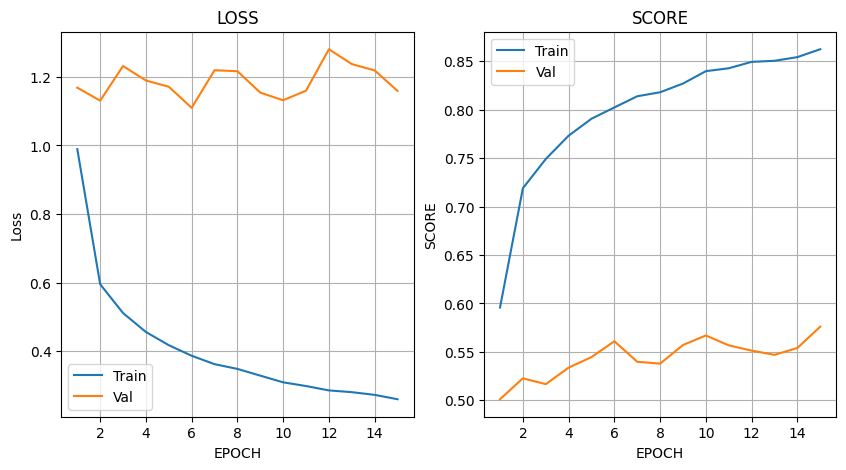

In [387]:
# 학습 후 LOSS 시각화
TH = len(loss_history[0])
fg, axes = plt.subplots(1,2, figsize=(10,5), sharex=True)

axes[0].plot(range(1,TH+1),loss_history[0][:TH], label='Train')
axes[0].plot(range(1,TH+1),loss_history[1][:TH], label='Val')
# axes[0].plot(range(1,TH+1),loss_history[2][:TH], label='Test')
axes[0].grid('--')
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,TH+1),f1score_history[0][:TH], label='Train')
axes[1].plot(range(1,TH+1),f1score_history[1][:TH], label='Val')
# axes[1].plot(range(1,TH+1),f1score_history[2][:TH], label='Test')
axes[1].grid('--')
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('SCORE')
axes[1].set_title('SCORE')
plt.show()
